In [70]:
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import mne
from dataclasses import dataclass

In [71]:
@dataclass
class EEG_Data:
    data: pd.core.frame.DataFrame = None
    raw_signal: np.ndarray = None
    filtered_signal: np.ndarray = None
    epoch_signal: np.ndarray = None
    title: str = None
    stimulus_frequency: float= None
    cut_start:int = None
    cut_end:int = None

In [72]:
# Source https://github.com/Mentalab-hub/explorepy/blob/master/examples/ssvep_demo/offline_analysis.py
def custom_filter(exg, lf, hf, fs, type):
    """
    
    Args:
        exg: EEG signal with the shape: (N_chan, N_sample)
        lf: Low cutoff frequency
        hf: High cutoff frequency
        fs: Sampling rate
        type: Filter type, 'bandstop' or 'bandpass'

    Returns:
        (numpy ndarray): Filtered signal (N_chan, N_sample)
    """
    N = 4
    b, a = signal.butter(N, [lf / (fs/2), hf / (fs/2)], type)
    return signal.filtfilt(b, a, exg)

# Signal filtering, bandpass 1-30Hz, bandstop 45-55Hz
def filt(sig,fs=250, lf=1, hf=30):
    filt_sig = custom_filter(sig, 45, 55, fs, 'bandstop') 
    filt_sig = custom_filter(filt_sig, lf, hf, fs, 'bandpass')
    return filt_sig

In [73]:
# Initialization
fs = 250 #Hz
lf = 1 #Hz
hf = 30 #Hz
chan_name = ['POz', 'PO3', 'PO4', 'PO7', 'O2', 'O1', 'Oz', 'PO8']
n_chan = len(chan_name)
chan_list = ['ch' + str(i) for i in range(1, n_chan + 1)]

In [74]:
# Import data
eeg_data = []
eeg_data.append(EEG_Data(pd.read_csv('data/vr_2/vr_75_ExG.csv'), title='VR (7.5 Hz)', stimulus_frequency = 7.5))
eeg_data.append(EEG_Data(pd.read_csv('data/vr_2/monitor_75_ExG.csv'), title='Monitor (7.5 Hz)', stimulus_frequency = 7.5))
eeg_data.append(EEG_Data(pd.read_csv('data/SSVEP_VR_1m/resting_ExG.csv'), title='VR (Resting)', stimulus_frequency = None))

In [75]:
# Add the signal data
for eeg in eeg_data:
    eeg.raw_signal = eeg.data[chan_list].to_numpy().T

# Filter the signal
for eeg in eeg_data:
    eeg.filtered_signal = filt(eeg.raw_signal, fs, lf, hf)
    

In [76]:
def amplitude_plot(filt_signal, chan_name, title = '', fs=250, lim = 150,xlim=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        ax.plot(t, filt_signal[i], label='{}'.format(chan_name[i]))

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(-1*lim, lim)
    if xlim:
        ax.set_xlim(0, xlim)
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


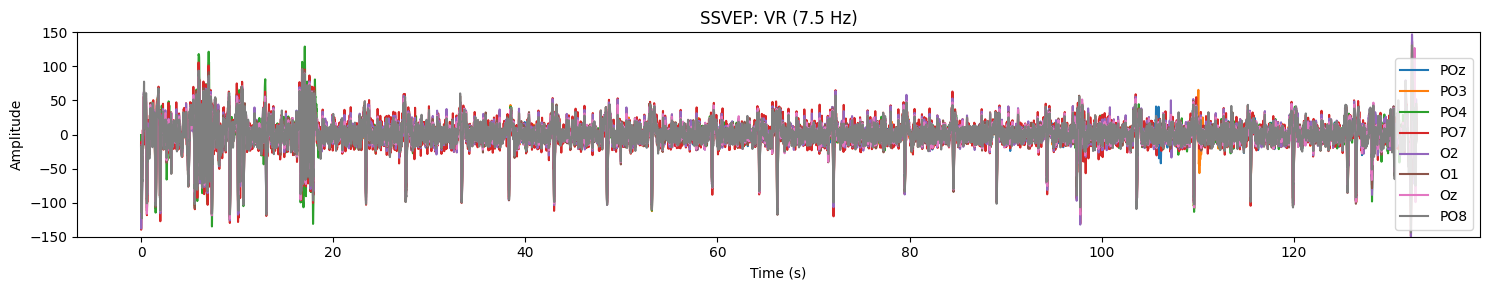

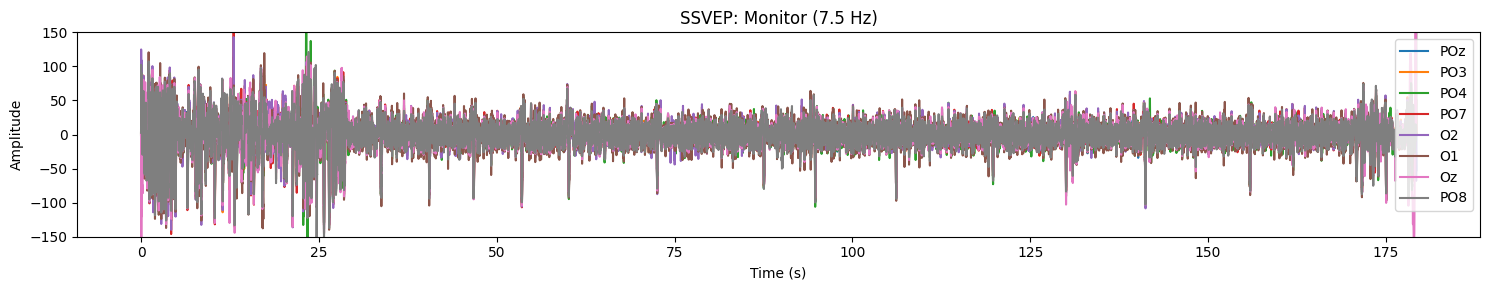

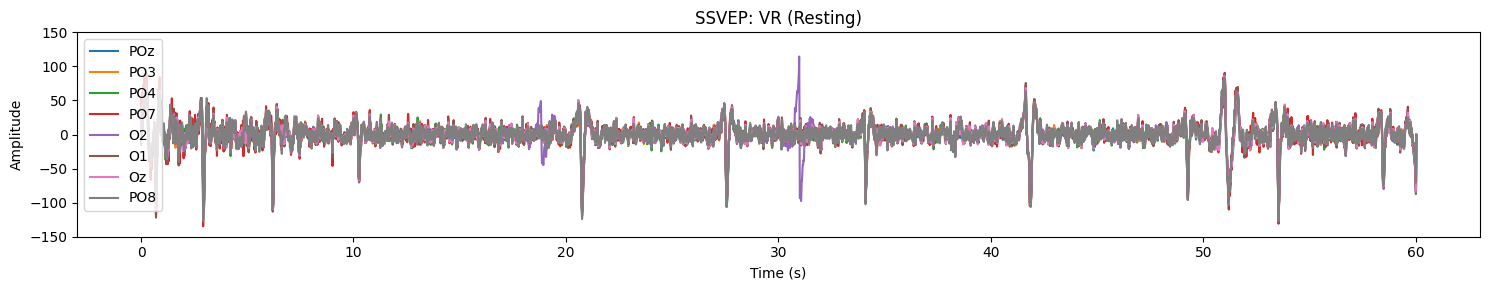

In [77]:
# Plot the signal amplitude VS time
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title))

In [78]:
# TODO: automate this
# add cut start and cut end
eeg_data[0].cut_start = 20
eeg_data[0].cut_end = 10

eeg_data[1].cut_start = 30
eeg_data[1].cut_end = 20

eeg_data[2].cut_start = 5
eeg_data[2].cut_end = 3

In [79]:
def cut_signal(filt_signal, start, end, fs=250):
    cut_start = int(start * fs)
    cut_end = int(end * fs)
    output = []
    
    for i in range(0,len(filt_signal)):
        output.append(filt_signal[i][cut_start:len(filt_signal[i])-cut_end])
    return np.array(output)

In [80]:
# Cut the signal so that the first 20 seconds and the last 10 seconds are removed
for eeg in eeg_data:
    eeg.filtered_signal = cut_signal(eeg.filtered_signal,eeg.cut_start,eeg.cut_end)

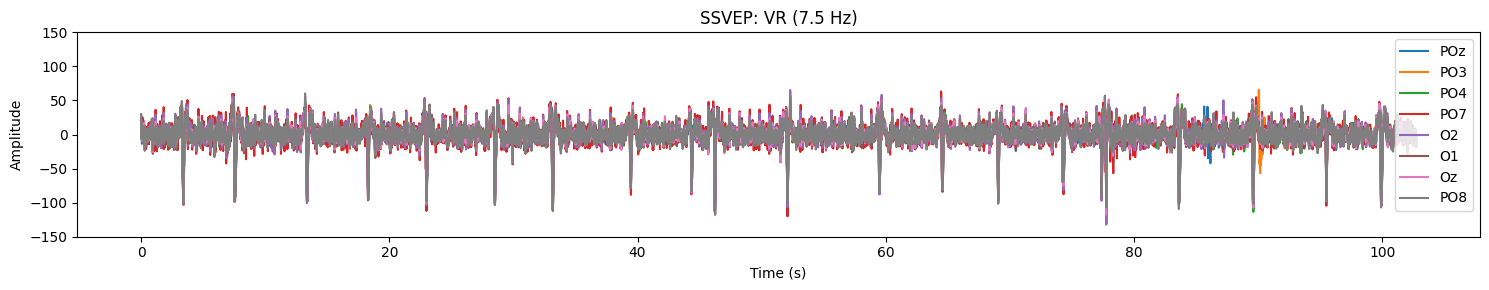

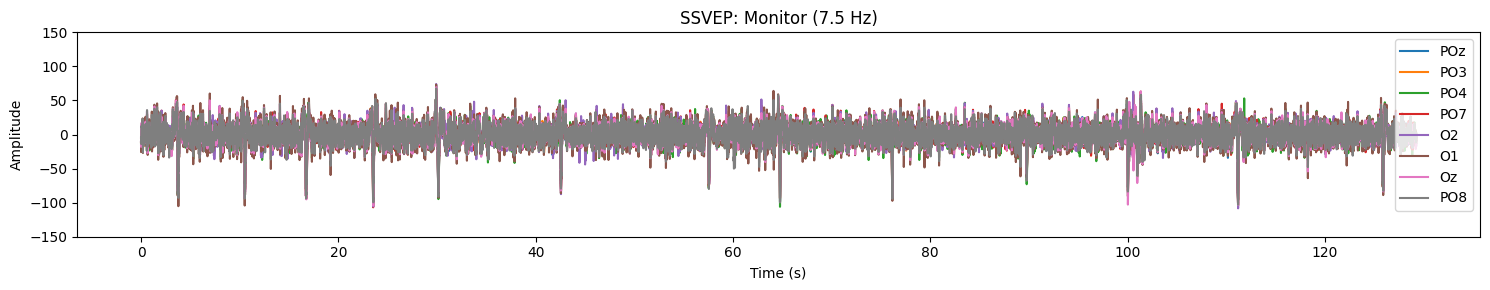

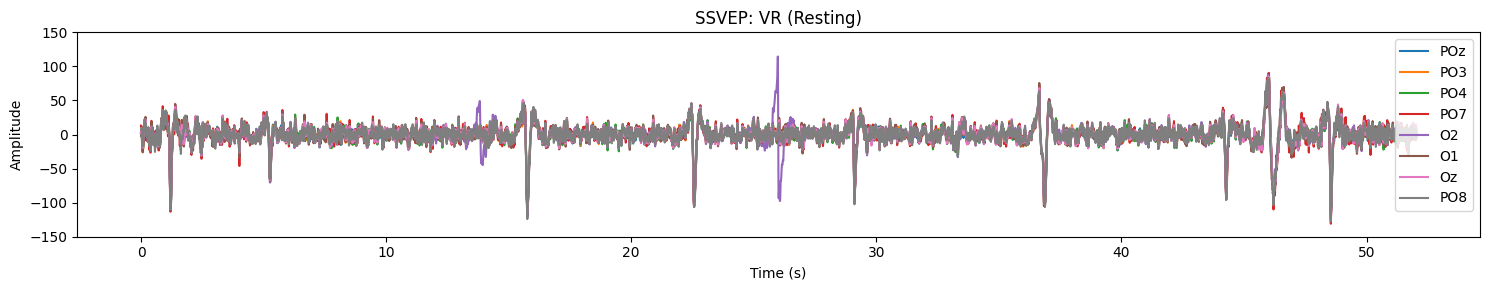

In [81]:
# Plot the signal amplitude VS time
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title))

In [87]:
def psd_plot(filt_signal, chan_name, title='', fs=250, x_min=1, x_lim=30, y_lim = 125, line=None):
    n_samples = filt_signal.shape[1]

    # Generate a time vector for the signal
    t = np.arange(n_samples) / fs

    # Create a single plot with a single subplot
    fig, ax = plt.subplots(figsize=(7, 3))

    # Loop through each signal and plot it on the same subplot
    for i in range(len(filt_signal)):
        f, psd = signal.welch(filt_signal[i], fs=fs, nperseg=10*fs, noverlap=0, nfft=10*fs)
        ax.plot(f, psd, label='{}'.format(chan_name[i]))

    if line:
        ax.axvline(x=line, color='gray', linestyle='--')
        ax.text(line+0.2, 20, 'f = '+str(line)+'Hz', fontsize=12, color='gray')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(x_min, x_lim)
    ax.set_ylim(0, y_lim)
    ax.legend()
    ax.set_title('PSD ' + title)
    plt.tight_layout()
    plt.show()


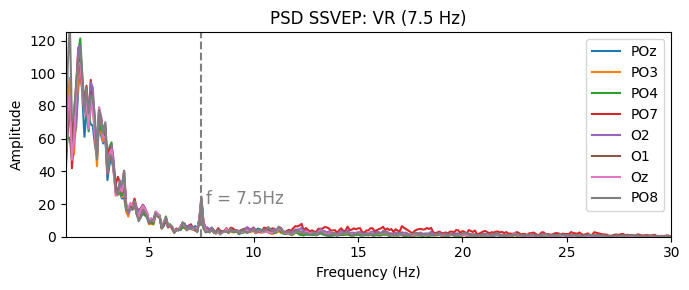

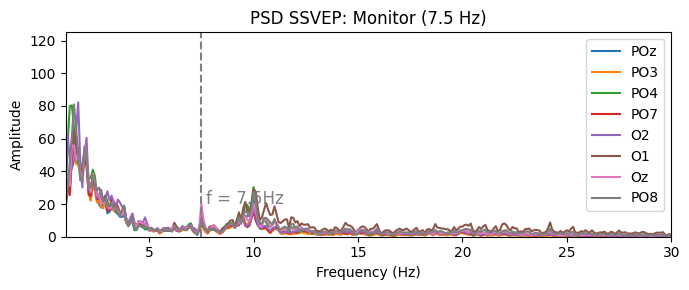

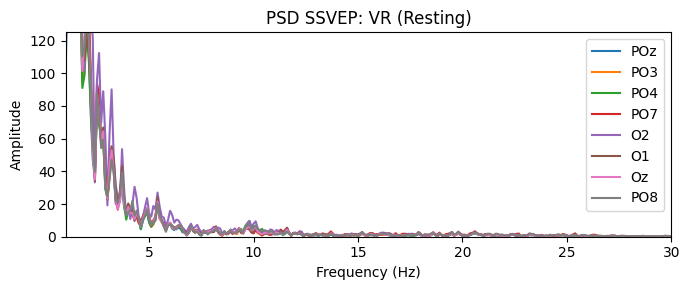

In [88]:
# Plot the signal PSD
for eeg in eeg_data:
    psd_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title), line=eeg.stimulus_frequency)

In [84]:
def reshape_to_epochs(data, epoch_length=6, sfreq=250):
    n_channels, n_samples = data.shape
    n_epochs = int(n_samples / (epoch_length * sfreq))
    epoch_samples = epoch_length * sfreq
    epoch_data = np.zeros((n_epochs, n_channels, epoch_samples))
    
    for i in range(n_epochs):
        start = i * epoch_samples
        end = start + epoch_samples
        epoch_data[i] = data[:, start:end]
    
    return epoch_data

In [98]:
%%capture 

# Plot the signal PSD
for eeg in eeg_data:
    psd_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title))

for eeg in eeg_data:
    eeg.epochs = reshape_to_epochs(eeg.filtered_signal)

freqs = np.arange(5., 12., .3)
n_cycles = freqs
t_min, t_max = 1, 6

class_names = []
for eeg in eeg_data:
    class_names.append(eeg.title)

times = np.linspace(t_min, t_max, eeg_data[0].epochs.shape[2])

power = []
for eeg in eeg_data:
    power.append(mne.time_frequency.tfr_array_morlet(eeg.epochs, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power'))

power_stack = np.stack(power)

for pow in power:
    mne.baseline.rescale(pow, times, (None, times[0]), mode='mean', copy=False)
    
power = power_stack

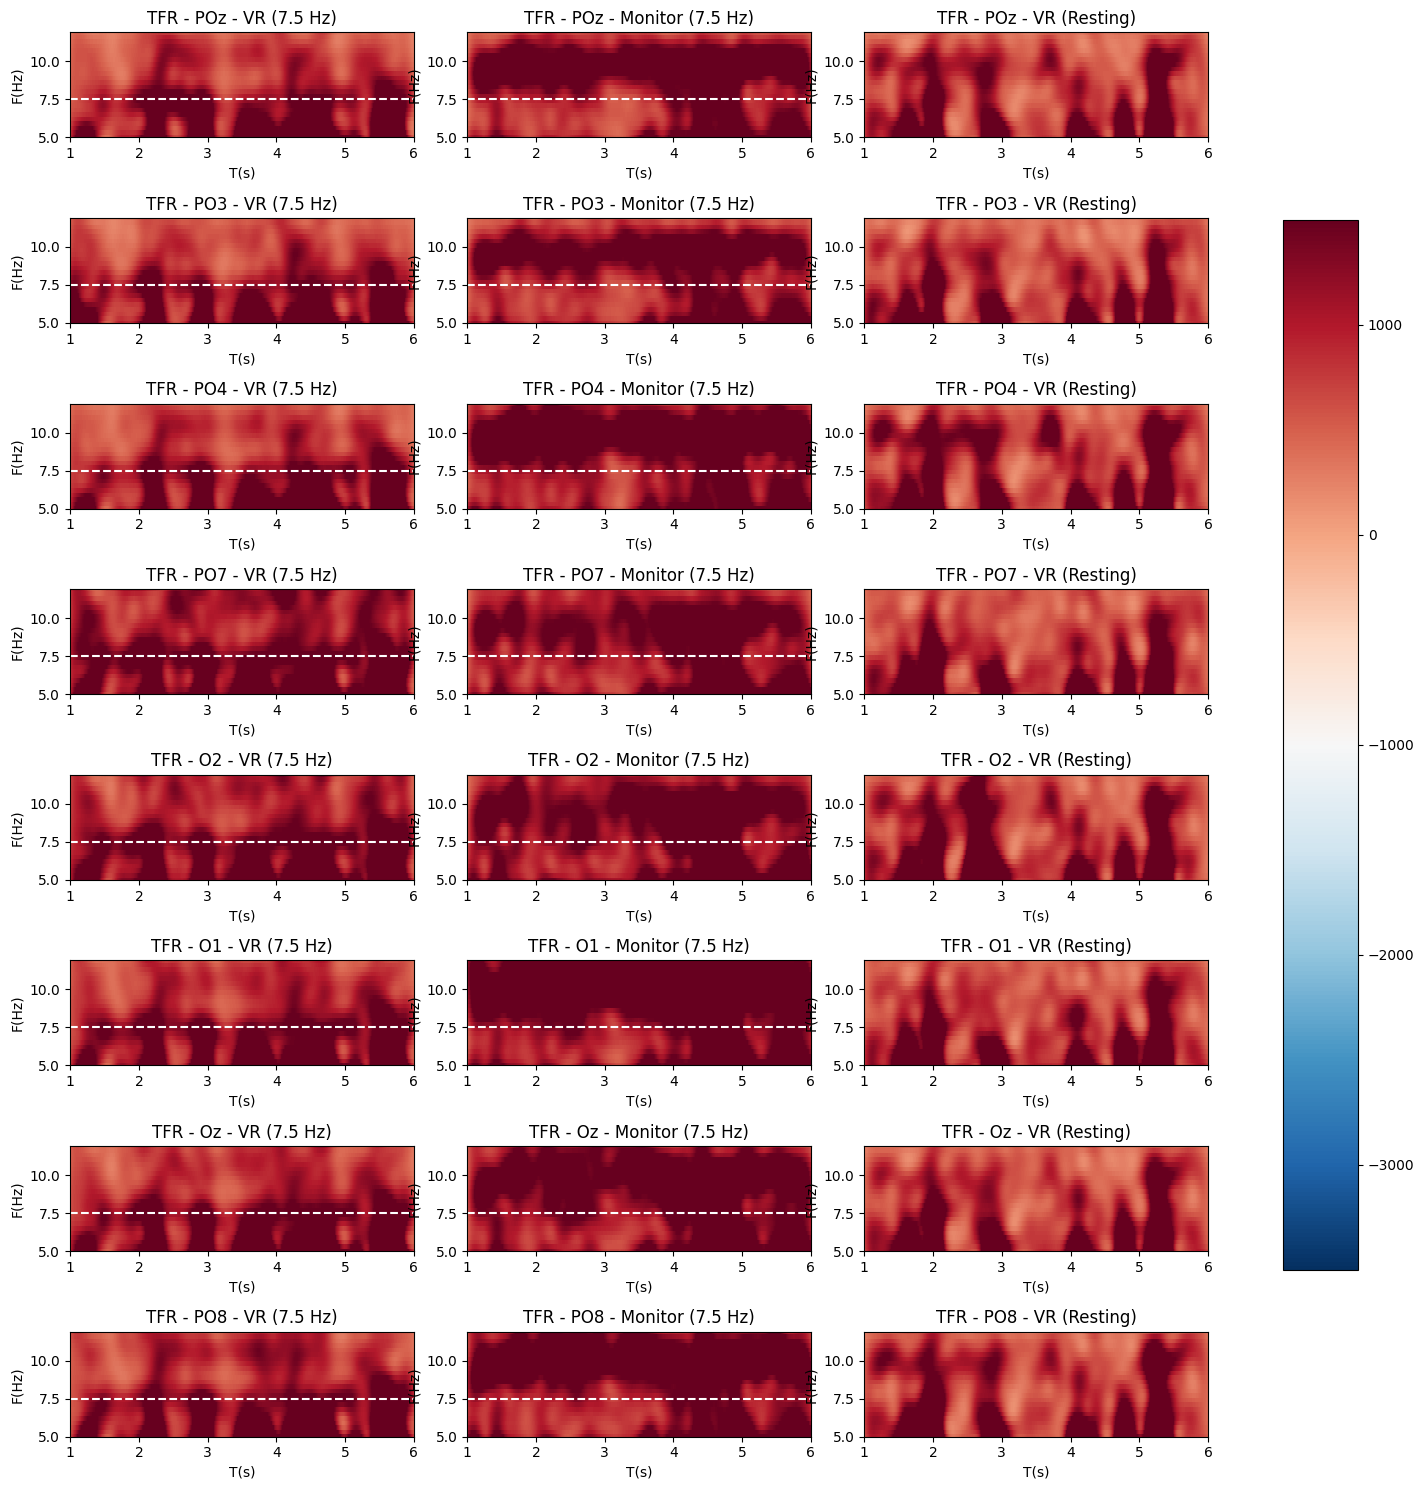

In [100]:
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_chan, len(class_names), figsize=(15, 15))
for j in range(len(class_names)):
    for i in range(n_chan):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
        if eeg_data[j].stimulus_frequency:
            ax[i, j].axhline(y=eeg_data[j].stimulus_frequency, linestyle='--', color='white')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()